# Dask 简介

Dask 是一个面向 Python 的并行计算框架，可以将计算任务扩展到多核和集群上。它提供了两类 API：高层的 DataFrame 和 Array 模拟了 pandas 和 NumPy 的 API，开箱即用；底层的基于计算图的 API 可以与很多 Python 包相结合。基于这两种 API，Dask 已经形成了一些生态，以应对越来越大的数据量和各种各样数据科学任务。

Dask 的核心思想是构建任务计算图（Task Graph），将一个大计算任务分解为任务（Task），每个任务调用那些单机的 Python 包（比如 pandas 和 NumPy）作为执行后端。

下图展示了 Dask API 和 Task Graph 并最后调度到计算设备上的示意图。

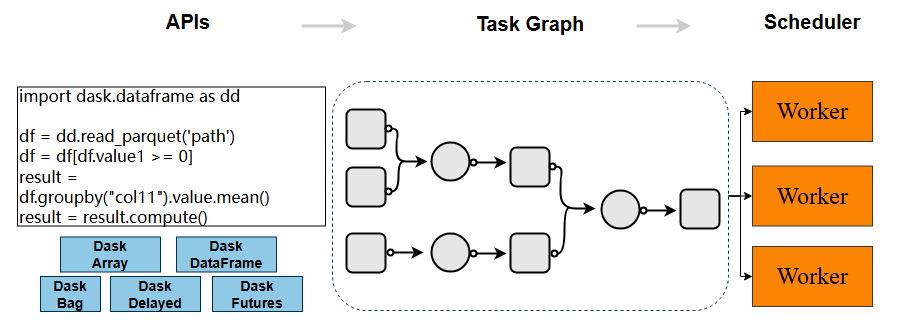

Dask 是一个面向大数据的并行计算框架，但 Dask 官方给用户的建议是：如果数据可以放进单机内存，建议优先使用传统的单机 Python 包。因为并不是所有的计算都很容易被并行化，有些任务甚至并行之后的性能反而下降。

安装 Dask 也很简单，使用 pip 或者 conda 安装所需要的包：

`pip install dask`

安装好后，我们就可以将 Dask 运行在单机的多个核心上。本书先从单机场景开始，多机场景只需修改一下调度器（Scheduler）即可。

# Dask DataFrame 快速入门

我们先使用 Dask DataFrame 演示一下如何使用 Dask 并行化 pandas DataFrame。

## 创建 Dask DataFrame

使用 Dask 内置的方法创建一个名为 ddf 的 DataFrame，这份数据是一个时间序列数据，是随机生成的，每个数据样本代表一秒钟，共计 4 天（从 2024-01-01 0:00 至 2024-01-05 0:00）。

In [2]:
import dask

ddf = dask.datasets.timeseries(start="2024-01-01", end="2024-01-05")
ddf

,name,id,x,y
npartitions=4,,,,
2024-01-01,string,int32,float64,float64
2024-01-02,...,...,...,...
2024-01-03,...,...,...,...
2024-01-04,...,...,...,...
2024-01-05,...,...,...,...


**pandas 所有操作是立即（Eager）执行的。Dask 是延迟（Lazy）执行的，数据并没有开始计算，所以都用省略号 … 表示。**

虽然 ddf 的数据还没有被计算，但 Dask 已经获取了数据的列名和数据类型，用 dtypes 查看列：

In [3]:
ddf.dtypes

name    string[pyarrow]
id                int32
x               float64
y               float64
dtype: object

## 执行计算

如果想计算并得到结果，必须使用 compute() 手动触发计算。

In [3]:
ddf.compute()

,name,id,x,y
timestamp,,,,
2024-01-01 00:00:00,Tim,1032,0.829467,-0.657813
2024-01-01 00:00:01,Ray,997,0.707054,0.863912
2024-01-01 00:00:02,Wendy,1010,0.697891,0.837233
2024-01-01 00:00:03,Michael,987,-0.041922,0.217946
2024-01-01 00:00:04,Michael,998,-0.932112,-0.776110
...,...,...,...,...
2024-01-04 23:59:55,Ray,934,-0.210997,-0.597951
2024-01-04 23:59:56,Victor,1046,0.451991,0.961664
2024-01-04 23:59:57,Jerry,995,-0.584932,0.147223


Dask DataFrame 有一个重要的内置变量 npartitions，它表示将数据切分成了多少份，或者说一共有多少个分区（Partition）。如下图所示，Dask DataFrame 是由多个 pandas DataFrame 组成的，每个 pandas DataFrame 又被称作一个 Partition。

In [4]:
ddf.npartitions

4

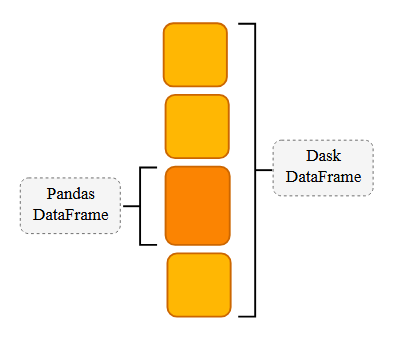

每个 Partition 有上界和下界。这个例子中 ddf 是根据时间列进行的切分，每天的数据组成一个 Partition。内置变量 divisions 存放着每个 Partition 的分界线：

In [5]:
ddf.divisions

(Timestamp('2024-01-01 00:00:00'),
 Timestamp('2024-01-02 00:00:00'),
 Timestamp('2024-01-03 00:00:00'),
 Timestamp('2024-01-04 00:00:00'),
 Timestamp('2024-01-05 00:00:00'))

## 索引

pandas DataFrame 有一列专门存放索引（Index），Index 可以是数字，比如行号；也可以是时间。Index 列通常只用于索引，不作为数据字段，在 ddf.dtypes 中看不到 Index 列。

本例中，ddf 的 Index 是时间。每个 Partition 基于 Index 列进行切分。整个 ddf 是四天的数据，每个 Partition 是一天的数据。

现在我们选择 2024-01-01 0:00 至 2024-01-02 5:00 的数据，横跨了两天，横跨了两个 Partition。

In [6]:
ddf["2024-01-01 0:00": "2024-01-02 5:00"]

,name,id,x,y
npartitions=2,,,,
2024-01-01 00:00:00.000000000,object,int32,float64,float64
2024-01-02 00:00:00.000000000,...,...,...,...
2024-01-02 05:00:59.999999999,...,...,...,...


还是需要使用 compute() 来触发计算，得到结果：

In [7]:
ddf["2024-01-01 0:00": "2024-01-02 5:00"].compute()

,name,id,x,y
timestamp,,,,
2024-01-01 00:00:00,Tim,1032,0.829467,-0.657813
2024-01-01 00:00:01,Ray,997,0.707054,0.863912
2024-01-01 00:00:02,Wendy,1010,0.697891,0.837233
2024-01-01 00:00:03,Michael,987,-0.041922,0.217946
2024-01-01 00:00:04,Michael,998,-0.932112,-0.776110
...,...,...,...,...
2024-01-02 05:00:55,Ursula,1024,0.562105,0.820668
2024-01-02 05:00:56,Quinn,984,-0.340150,-0.884951
2024-01-02 05:00:57,Ingrid,983,-0.940458,-0.461559


## pandas 兼容

Dask DataFrame 的大部分操作与 pandas 几乎一致，我们可以像使用 pandas 那样使用 Dask DataFrame。

比如数据过滤和 groupby：

In [8]:
ddf2 = ddf[ddf.y > 0]
ddf3 = ddf2.groupby("name").x.std()
ddf3

Dask Series Structure:
npartitions=1
    float64
        ...
Name: x, dtype: float64
Dask Name: sqrt, 9 graph layers

现在的结果仍然用省略号 … 表示，因为计算被延迟执行，需要调用 compute() 触发执行。

In [9]:
computed_ddf = ddf3.compute()
computed_ddf

name
Alice       0.579123
Bob         0.580156
Charlie     0.575598
Dan         0.576901
Edith       0.577096
Frank       0.574307
George      0.580490
Hannah      0.577393
Ingrid      0.576164
Jerry       0.579826
Kevin       0.580706
Laura       0.572466
Michael     0.571673
Norbert     0.578293
Oliver      0.573743
Patricia    0.574757
Quinn       0.578486
Ray         0.582240
Sarah       0.576790
Tim         0.576738
Ursula      0.574005
Victor      0.575547
Wendy       0.574329
Xavier      0.581869
Yvonne      0.581161
Zelda       0.584215
Name: x, dtype: float64

## 计算图

至此，我们知道 Dask DataFrame 将大数据切分成了 Partition，并且延迟执行的。Dask 构建了 Task Graph，来分别对每个 Partition 进行了计算。

执行 compute() 之前，Dask 构建的是一个计算图 Task Graph，用 visualize() 可视化 Task Graph。

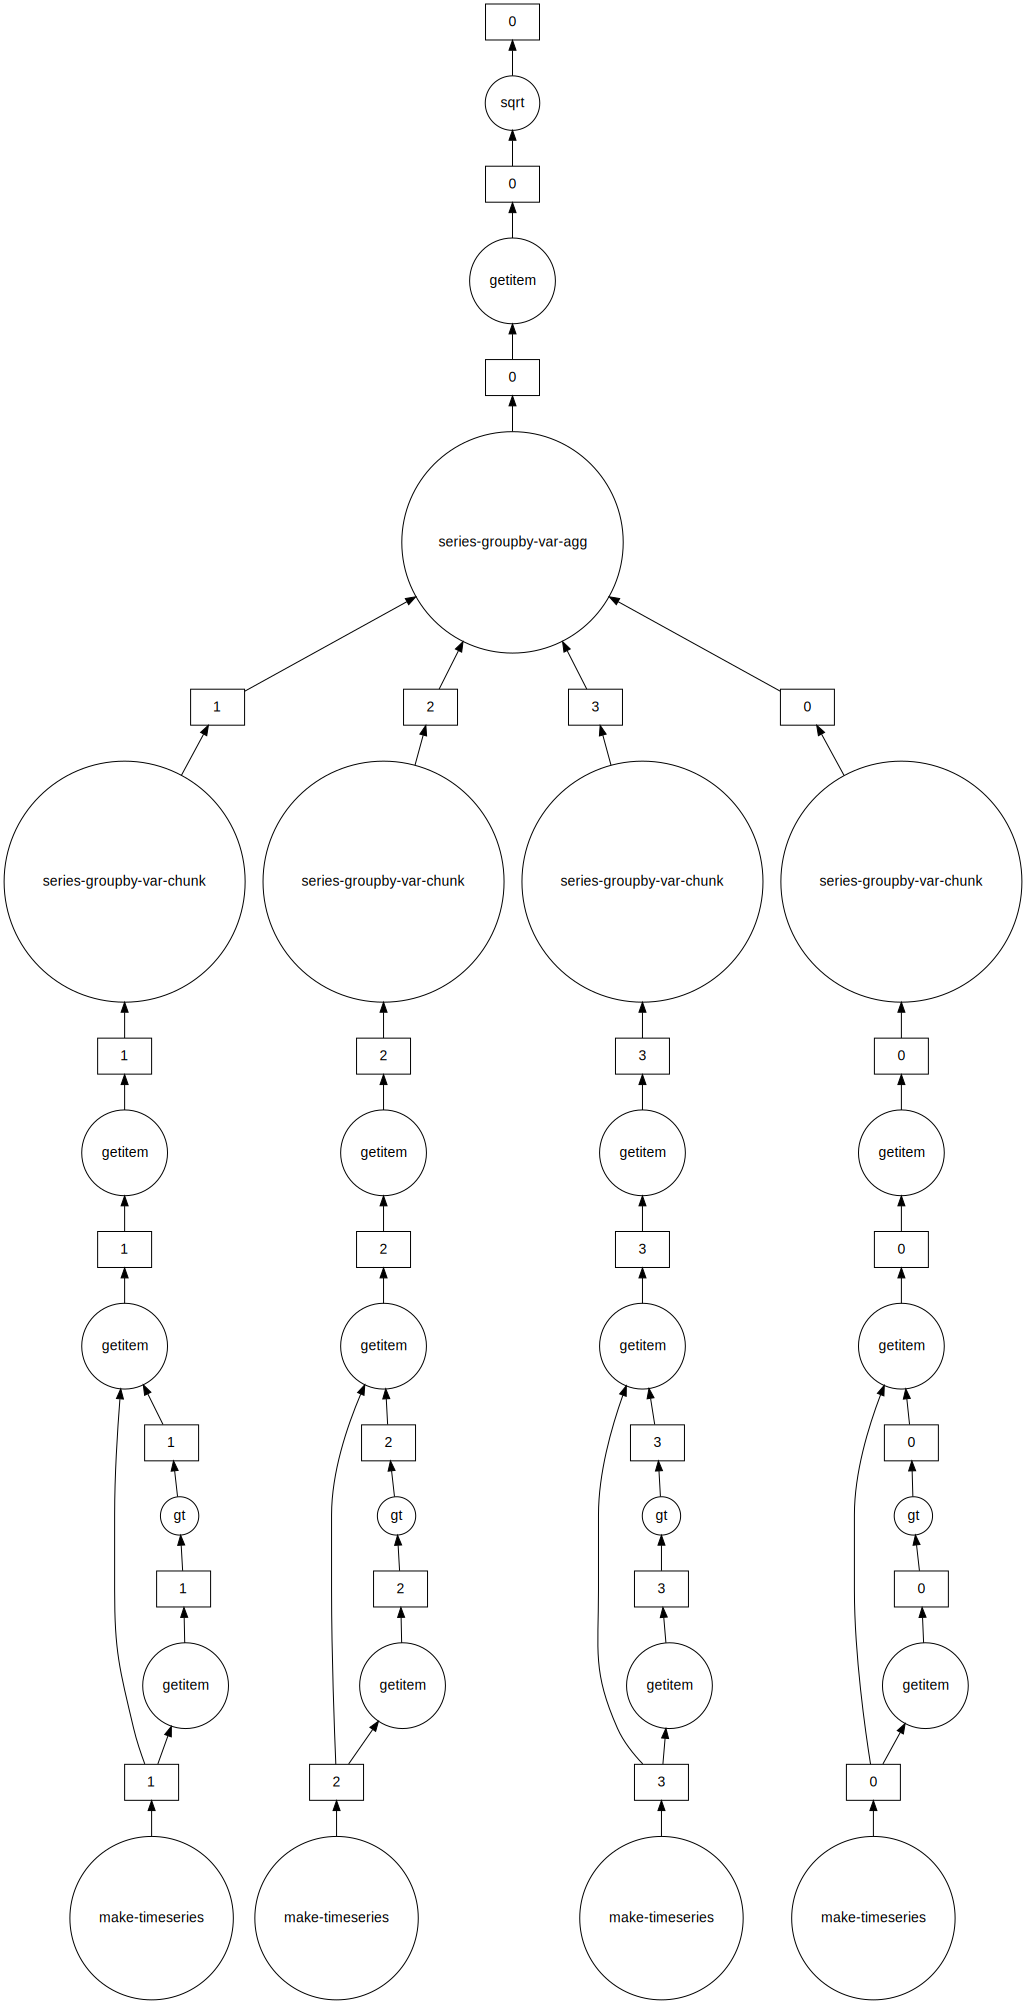

In [26]:
ddf3.visualize(filename="images/visualize-task-graph", format="svg")

计算图中，圆圈表示计算，长方形表示数据。对于 Dask DataFrame 来说，长方形就是 pandas DataFrame。

# 将 Dask 扩展到集群

刚刚的任务都是在单机场景下使用 Dask。dask.distributed 可以帮助我们把 Dask 任务扩展到多台计算节点。



## Dask集群

如下图所示，一个 Dask 集群必须包含一个调度器（Scheduler）和多个工作节点（Worker）。用户通过客户端（Client）向调度器提交计算任务，调度器对任务进行分析，生成 Task Graph，并将 Task 分发到多个 Worker 上。每个 Worker 承担一小部分计算任务，Worker 之间也要互相通信，比如计算结果的归集等。

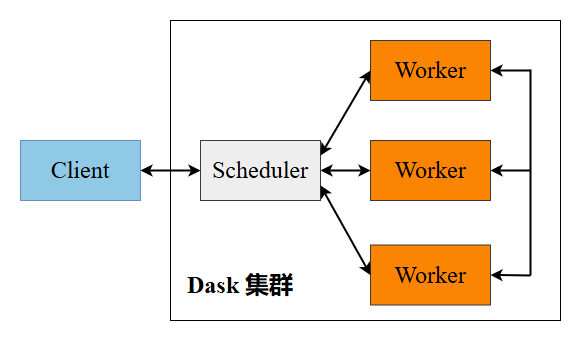

Scheduler 和 Worker 共同组成了一个 Dask 集群。

默认情况（不进行任何额外的设置），Dask 会启动一个本地的集群 LocalCluster，并使用客户端 Client 连接这个集群。

In [3]:
from dask.distributed import LocalCluster, Client

cluster = LocalCluster()
cluster

LocalCluster(0ddf0e36, 'tcp://127.0.0.1:54810', workers=4, threads=8, memory=15.83 GiB)

Dask 探测到本地资源情况，比如本地有 4 个 CPU 核心、16GB 内存，根据本地资源创建了一个 LocalCluster。这个 LocalCluster 有 4 个 Worker，每个 Worker 对应一个 CPU 核心。

Dask 同时提供了**仪表盘（Dashboard）链接**，可以在网页中查看集群和作业的具体信息。

使用 Client 连接这个 LocalCluster，连接之后，Dask 所有的计算将提交到这个 LocalCluster 上：

In [4]:
client = Client(cluster)

## 使用命令行启动一个 Dask 集群

### 启动 Dask 集群

当我们有更多的计算节点时，可以使用命令行在不同的计算节点上启动 Dask Scheduler 和 Dask Worker。比如，在 IP 地址为 192.0.0.1 的计算节点上启动 Dask Scheduler，在命令行里输入下面的命令。

Dask 将日志信息打印出来，其中 Dask Scheduler 的 IP 和端口号为：tcp://192.0.0.1:8786

在其他计算节点上启动 Worker，这些 Worker 要连接到刚刚启动的 Scheduler 上。在 dask worker 命令后面添加刚刚得到的 Dask Scheduler 的 IP 地址和端口号。比如，在 192.0.0.2 上启动 Dask Worker：

Dask Scheduler 默认使用 8786 作为连接端口号，如果使用其他端口号，需要使用 --port 告知 Dask 使用该端口。

除了 --port 之外，Dask Scheduler 还有很多其他参数，用户可以根据自身需要设置。

### 连接 Dask 集群

假如 Dask Scheduler 启动后返回的地址为 192.0.0.1:8786，使用下面的代码连接到这个集群上，基于 Dask Array、Dask DataFrame 的 .compute() 的代码会自动调度到这个集群上。

In [13]:
from dask.distributed import Client

client = Client("192.0.0.1:8786")


KeyboardInterrupt



## Python 环境和依赖包管理

在集群上使用 Dask 时，要注意所有计算节点都安装所需要的 Python 依赖包。

可以使用 distributed.diagnostics.plugin.PipInstall 在运行时给每个 Worker 安装依赖包。PipInstall 的 packages 参数接收一个列表，列表内容为依赖包的名字，它会像 pip install 那样安装这些依赖包。安装的过程发生在程序真正开始前，会消耗一定时间，因此这种方式更适合原型测试阶段，还不确定哪些包需要，哪些不需要。

In [14]:
from dask.distributed import PipInstall
plugin = PipInstall(packages=["scikit-learn"], pip_options=["--upgrade"])
client.register_plugin(plugin)

AttributeError: 'Client' object has no attribute 'register_plugin'

等最终确定了所需要的依赖包，最好使用以下方式管理集群上的 Python 和各个依赖包：

- 所有计算节点安装同样版本的软件：比如，使用 conda 或者 pip 在每个 Dask Worker 同样的目录下安装 Python 和依赖包。

- 所有计算节点挂载共享文件系统：Python 等软件环境安装到共享文件系统中，所有 Dask Worker 看到的是相同的目录和相同的内容。常见的共享文件系统有网络文件系统（Network File System，NFS）。

- 使用容器：Python 及依赖包都打包到容器中，在集群上分发容器，每个计算节点都启动相同的容器。

## SSH、Kubernetes、高性能计算集群

Dask 集群本质就是 Dask Scheduler 和一系列 Dask Worker，其他各类具体部署场景都大同小异。Dask 针对不同部署场景提供了封装好的库，用户无需像刚才那样分别登陆到不同节点，依次启动 Dask Scheduler 和 Dask Worker。下面将介绍三种类型：SSH、Kubernetes 和高性能计算集群。

### SSH

只要知道每台计算节点的 IP 地址或者主机名（Hostname），就可以在 Python 代码或者命令行中启动 Dask 集群。 dask.distributed.SSHCluster 基于 asyncssh 包进行了封装，它 SSH 登录到每个计算节点，然后在该节点启动 Dask Scheduler 或 Dask Worker。

如果你在个人电脑上操作 SSHCluster，即个人电脑是 Client，各个计算节点组成集群，你应该将个人电脑与各个计算节点之间设置免密码登录。确切地说，各个计算节点的 authorized_keys 文件中应该存储了个人电脑的公钥。

可以使用 Python 代码启动这个 Dask 集群：

hosts 是要拉起 Dask 的主机列表，列表上第一个节点将启动 Dask Scheduler，其余节点启动 Dask Worker；connect_options 是 SSH 登录的一些参数，比如用户名 username、密码 password、端口号 port，这些参数以 {"key": "value"} 的形式传递给 Dask。

### Kubernetes

Kubernetes 已经成为云资源管理事实上的标准，使用 Kubernetes 安装软件最简单的方式是使用 Helm。Dask 封装了 dask-kubernetes，并提供了 KubeCluster 和 HelmCluster 两个类。

### 高性能计算集群

高性能计算（High-Performance Computing）集群通常使用 Slurm 等调度软件。Dask 为高性能集群封装了 dask-jobqueue，兼容 Slurm 在内的调度软件。

比如，使用 SLURMCluster 向 Slurm 的 cpu 队列申请 10 个节点用于运行 Dask Worker，每个节点资源为 32 核 128GB。scale() 方法会向 Slurm 申请 10 计算节点。

相比于云上资源，高性能计算集群除了配备常见的以太网，还配备了高带宽和低延迟的 RDMA 网络，（比如，InfiniBand）。RDMA 网络能加速很多对网络要求高的任务。如果想充分利用 RDMA 网络，可以在 SLURMCluster 的 interface 参数传入网卡接口。网卡接口可以在命令行里使用 ifconfig 查看，比如 InfiniBand 网卡一般对应为 ib0，以太网一般显示为 eth0 。不同的计算节点的网卡命名可能不一样。如果不设置 interface，Dask 默认使用以太网。

### 自动缩放

前面介绍的 Kubernetes 和高性能计算集群（例如 Slurm）均支持自动缩放（Auto-Scaling 或 Adaptive Scaling），因为他们本身就是集群调度管理软件，他们管理着大量计算资源，不同的应用向他们请求资源。Dask 构建在 Kubernetes 或 Slurm 上，相当于在 Kubernetes 或 Slurm 所管理的计算资源上申请一个子集。在 Kubernetes 或 Slurm 上，我们可以使用 Dask 的自动缩放技术，自动增加或减少 Dask 所需计算资源。自动缩放主要考虑以下场景：

用户当前作业对计算资源要求很高，需要更多的资源来满足计算需求。

用户当前作业所申请的计算资源闲置，这些资源可被其他用户使用。尤其是当用户进行交互式数据可视化，而非大规模计算时。

KubeCluster 和 SLURMCluster 都提供了 adapt() 方法。下面的例子可以在 0 到 10 个 Worker 之间动态缩放。自动缩放根据 Dask Scheduler 上作业的负载来决定运行多少个 Dask Worker。Dask 收集一些信息，比如每个 Dask Worker 上已用内存和可用内存，并根据这些信息自适应地调整计算资源数量。

In [15]:
from dask_kubernetes import KubeCluster

cluster = KubeCluster()
cluster.adapt(minimum=0, maximum=10)

ModuleNotFoundError: No module named 'dask_kubernetes'

### Dask Nanny

Dask 在启动集群时，除了启动 Dask Scheduler 和 Dask Worker 外，还启动了一个叫做 Dask Nanny 的监控服务。Nanny 英文意为保姆，Dask Nanny 就是在执行保姆的作用，它监控着 Dask Worker 的 CPU 和内存使用情况，避免 Dask Worker 超出资源上限；Dask Worker 宕机时，Dask Nanny 负责重启 Dask Worker。如果某个 Dask Worker 被 Dask Nanny 重启了，该 Dask Worker 上的计算任务被重新执行，其他 Dask Worker 保留当时状态和数据，并一直等待该 Dask Worker 恢复到刚刚宕机的时间点；这会给其他 Dask Worker 增加很多负担。如果 Dask Worker 频繁重启，可能需要考虑用 rechunk() 或 repartition() 调整 Partition 的数据大小。

# GPU

GPU 以及其他异构计算加速器被广泛用来加速深度学习，Dask 社区联合 NVIDIA，提供了基于 GPU 的数据科学工具包，以加速各类任务。

## Dask GPU 集群

Dask-CUDA 对 dask.distributed 扩展，可以识别和管理 GPU 设备。

使用这些 GPU 设备前，先通过 `pip install dask_cuda` 安装 Dask-CUDA。跟3.3 提到的dask.distributed 类似，Dask-CUDA 提供了一个单机的 LocalCUDACluster，LocalCUDACluster 会自动发现并注册该计算节点上的多张 GPU 卡，每张 GPU 自动配比一定数量的 CPU 核心。比如，我的环境有 4 张 GPU 卡，启动一个单机 Dask 集群，会自动启动 4 个 Dask Worker，每个 Worker 一张 GPU 卡。

In [1]:
from dask_cuda import LocalCUDACluster
from dask.distributed import Client

cluster = LocalCUDACluster()
client = Client(cluster)
client

ImportError: Only Linux is supported by Dask-CUDA at this time

我们也可以启动一个 Dask GPU 集群，先启动 Dask Scheduler：

In [ ]:
dask scheduler

再在每个 GPU 节点上启动支持 GPU 的 Worker，构成一个 Dask GPU 集群。

In [ ]:
dask cuda worker tcp://scheduler:8786
        
client = Client("10.0.0.3:8786")
client

Dask-CUDA 只发现并注册这些 GPU，但无法做到 GPU 的隔离，其他非 Dask 的任务仍然可以抢占该 GPU。GPU 资源的隔离应该需要借助 Kubernetes 等容器技术。

## GPU 任务

并不是所有任务都能被 GPU 加速，GPU 主要加速一些计算密集型任务，比如机器学习和深度学习等。目前，Dask 支持的 GPU 上框架包括：

- [CuPy](https://cupy.dev/) 的 Dask 分布式版本

- [Dask-cuDF](https://docs.rapids.ai/api/dask-cudf/stable/) 将 GPU 加速版的 cuDF 横向扩展到 GPU 集群上

使用 NVIDIA 的 GPU 的各类库，应该将 CUDA 目录添加到 PATH 和 LD_LIBRARY_PATH 环境变量中，CuPy 和 cuDF 需要依赖所安装的动态链接库。

## 案例：奇异值分解

下面的代码在 GPU 上进行奇异值分解，是一种适合 GPU 加速的任务。设置 `dask.config.set({"array.backend": "cupy"}) `即可将 Dask Array 的执行后端改为 GPU 上的 CuPy。

In [ ]:
import cupy
import dask
import dask.array as da

dask.config.set({"array.backend": "cupy"})
rs = dask.array.random.RandomState(RandomState=cupy.random.RandomState)
x = rs.random((10000, 1000), chunks=(1000, 1000))
u, s, v = dask.array.linalg.svd(x)

# Task Graph 与数据切分

## Task Graph

和很多大数据计算框架一样，Dask 的计算图是有向无环图（Directed Acyclic Graph，DAG），Dask 称之为 Task Graph，可以通过 .visualize() 方法将 Task Graph 可视化出来。Task Graph 的本质是将众多小的计算任务（Task）组织起来，每个 Task 在单个 Worker 上执行计算。

比如下面这个例子，有两类Task：data(i) 接收输入数据；add(x, y) 对两个输入 x 和 y 做加法。

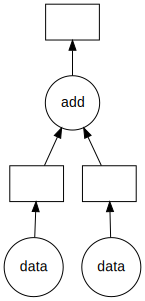

In [1]:
import dask.delayed as delayed

def data(i):
    return i

def add(x, y):
    return x + y

x = delayed(data)(1)
y = delayed(data)(2)
z = delayed(add)(x, y)

z.visualize(filename='../images/visualize.svg')

In [2]:
z = z.compute()
print(z)

3


在这个例子中，Dask Task Graph 一共有 3 个 Task，实现了数据输入和加法计算。Dask 的设计思想是将复杂的并行计算切分成 Task，每个 Task 是一个 Python 函数。.visualize() 可视化的 Task Graph 中，圆圈是函数，方框是数据占位符。Dask Scheduler 会生成 Task Graph，并将 Task Graph 中的各个计算任务分发到 Dask Worker 上。

值得注意的是，在将多个 Task 组合在一起时，我们使用了 dask.delayed，dask.delayed 是一个偏底层的接口，可以允许用户手动构建计算图。如果用户需要自定义某些任务，就可以使用 `dask.delayed` 这个装饰器，比如这样：

In [5]:
@dask.delayed
def f(x):
    x = x + 1
    return x

应该使用：dask.delayed(f)(x, y)，而非 dask.delayed(f(x, y))，因为 dask.delayed 修饰的是 Python 函数，而不是函数的输出结果。经过 dask.delayed 修饰的 Python 函数将构成 Task Graph 的一个节点，Dask 并没有创造新的计算引擎，而是通过 Task Graph 的方式将多个 Task 组织起来。Dask 所提供的各类复杂的功能都是基于此实现的。

## 数据切分

Dask 将大数据切分成很多个小数据，Dask Array 将切分的小数据称为块（Chunk）；Dask DataFrame 将切分的小数据称为分区（Partition）。虽然 Chunk 和 Partition 名词不同，但本质上都是数据的切分。

In [1]:
import dask.array as da
x = da.ones((10, 10), chunks=(5, 5))

y = x + x.T
y

dask.array<add, shape=(10, 10), dtype=float64, chunksize=(5, 5), chunktype=numpy.ndarray>

经过了数据切分后，共有 4 个 Chunk，Dask 对这 4 个 Chunk 分配了索引 Index，分别为：(0, 0)、(0, 1)、（1, 0）、(1, 1)。每个 Chunk 调用 NumPy 进行计算，必要时，还需要对多个 Chunk 进行聚合操作。下图给出了这个矩阵运算的 Task Graph。

In [5]:
y.visualize(filename='../images/transpose.svg')

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

在这个 Task Graph 中，圆圈是计算函数，比如 ones_like 代表 NumPy 的 np.ones_like() 方法，transpose 代表 NumPy 的 np.transpose() 方法；方块是数据占位符，表示经过了前一步计算得到的 NumPy 数据块。

## 数据切分粒度

数据切分的粒度会影响 Task Graph：

- 如果每个数据块很小，那么 Task Graph 将会很大

- 如果每个数据块很大，那么 Task Graph 将会很小

过大或者过小的数据块都不是最优解。

### 数据块过小

如果数据块过小，那么生成的 Task Graph 很大。据统计，Dask Scheduler 协调分发 Task Graph 中的一个计算任务平均需要 1 毫秒，如果 Task Graph 很大，Dask 将花费大量时间用在计算资源协调与分发上。

如果用一个比喻的话，Dask Scheduler 是包工头，Dask Worker 是建筑工人。现在要用很多块砖砌一堵墙，建筑工人将砖块搬到墙上，如果包工头在布置任务时，让每个建筑工人一次只搬一块砖，大量时间都花在了来回搬运上，实际上没有充分利用建筑工人的能力，而且包工头疲于指挥各个建筑工人。对于数据块过小的情况，一方面，Dask Worker 工作欠饱和；另一方面，Dask Scheduler 分发任务的负载也很重。这种场景下，Dask 会生成一个很大的 Task Graph，Dask 输出的日志中通常会带有一些提示，告知用户 Task Graph 过大，影响性能，需要用户优化数据切分方式。

### 数据块过大

数据块过大，则 Dask Worker 很容易内存耗尽（Out of Memory，OOM），因为所切分的数据块无法被单个 Dask Worker 所处理。Dask 遇到 OOM 时，会将部分数据卸载到（Spill）硬盘，如果 Spill 之后仍无法完成计算，Dask Worker 进程可能被重启，甚至反复重启。

## 迭代式算法

迭代式算法通常会使用循环，循环的当前迭代依赖之前迭代的数据。Dask 的 Task Graph 对于这类迭代式算法处理得并不好，每个数据依赖都会在 Task Graph 中增加有向边，进而会使得 Task Graph 非常庞大，导致执行效率很低。比如，很多机器学习算法、SQL JOIN 都是基于循环的迭代式算法，用户需要对这些操作有心理准备。

## 设置正确的数据块大小

总之，在做数据块切分时，不应过大，也不应过小。Dask 没有一个简单通用的设置原则，需要开发者根据自身数据的情况和 Dask 的仪表盘或日志来不断调整。

### 仪表盘

如下图所示，Dask 仪表盘提供了计算任务运行时信息，用户可以根据仪表盘信息来调整数据分块。

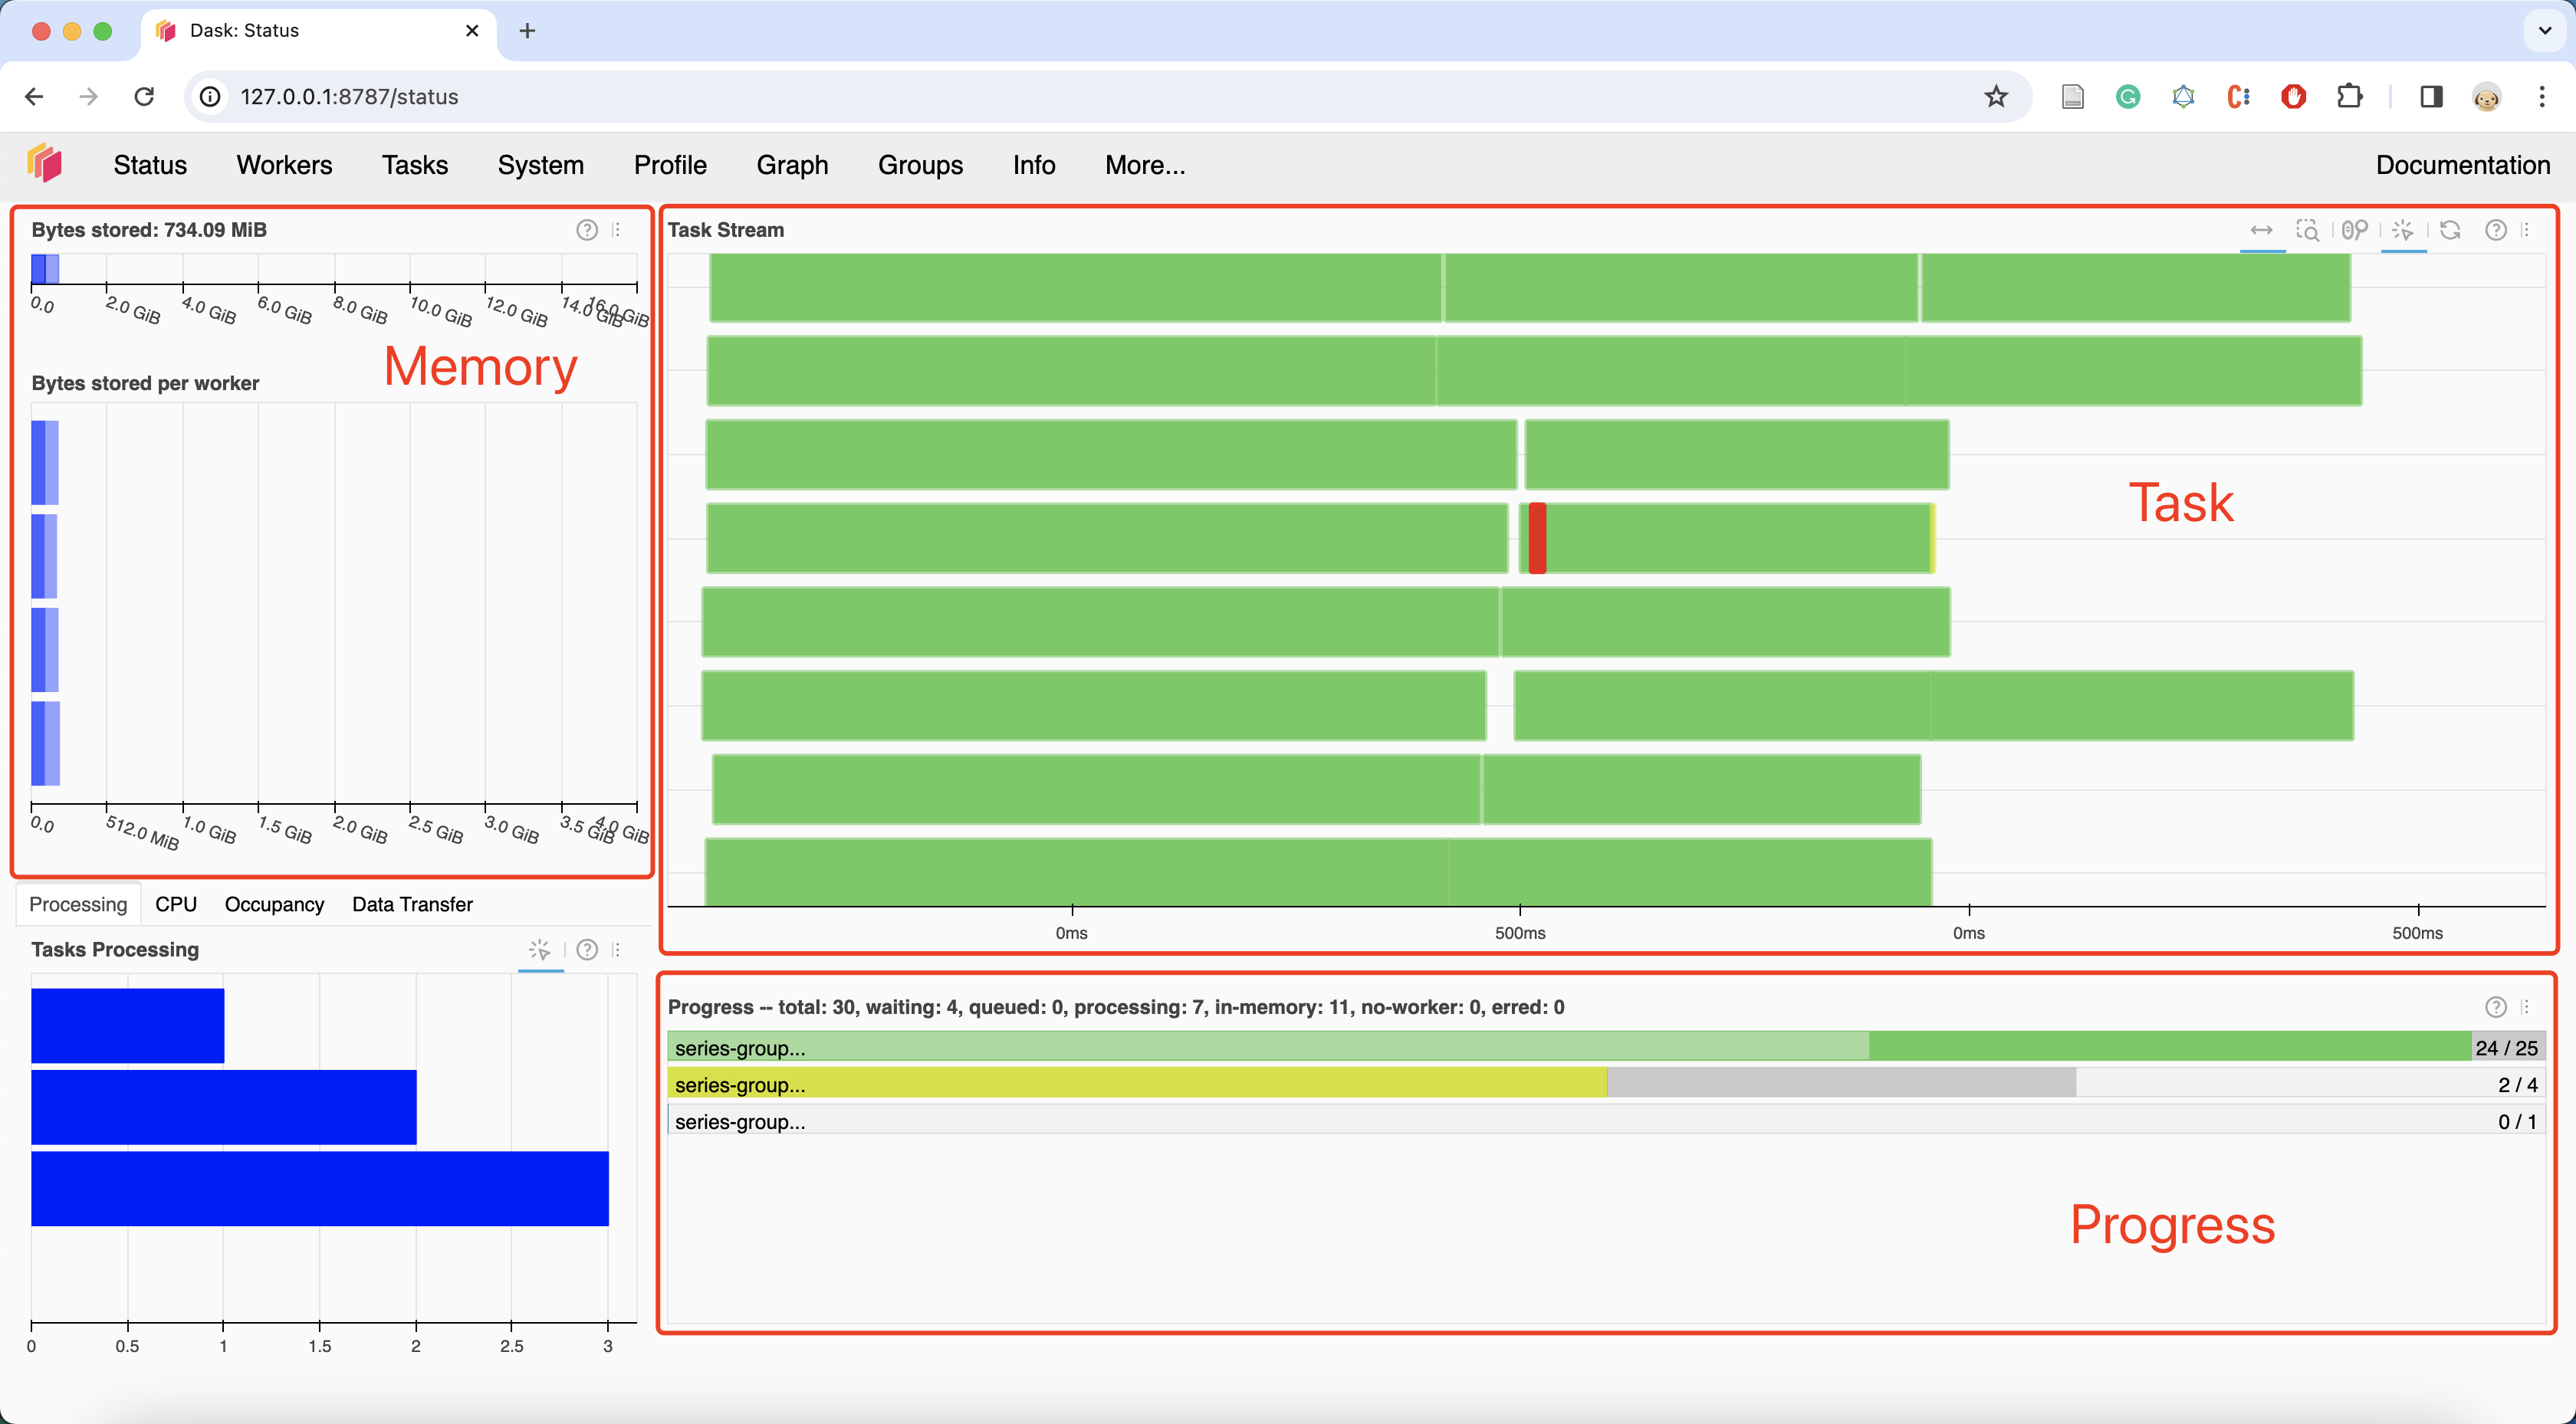

我们需要关注 Task Stream 栏，应该避免大量的空白或大量的红色。空白表示 Dask Worker 上没有任何任务，红色表示 Dask Worker 之间进行大量的数据交换。

下图1和下图2是一个对比，两张图使用代码相同，但是使用的数据块大小不同。图2中的数据块过小，Task Graph 过大，出现了大量的红色，时间没有用在计算上，而是浪费在数据交换等其他事情上。

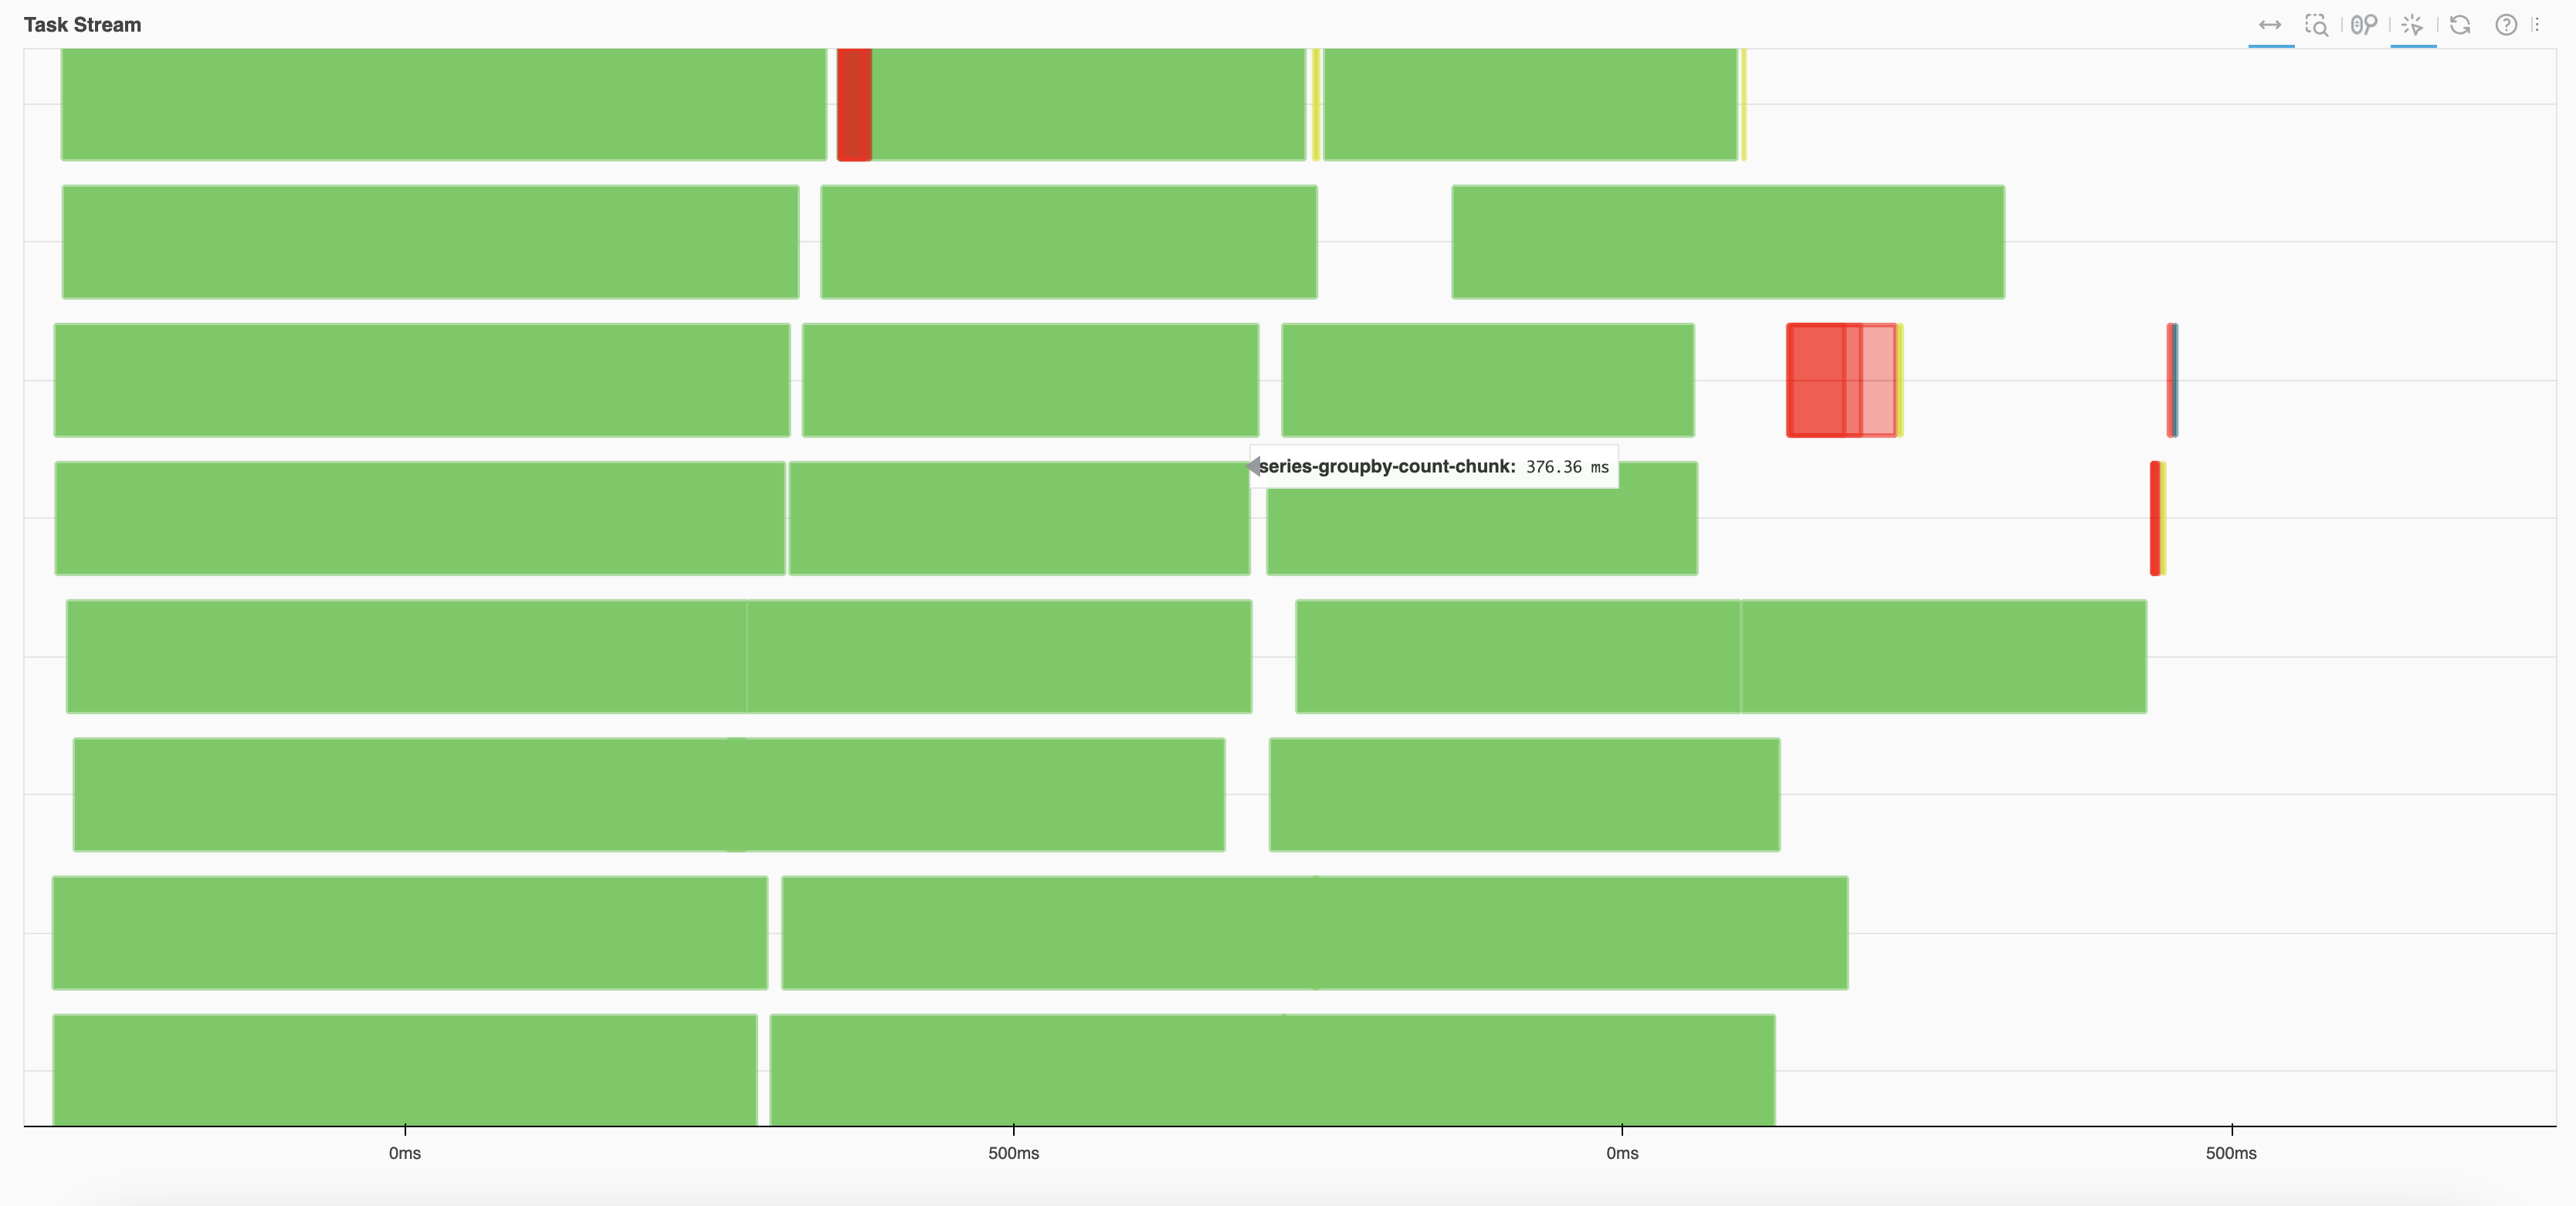

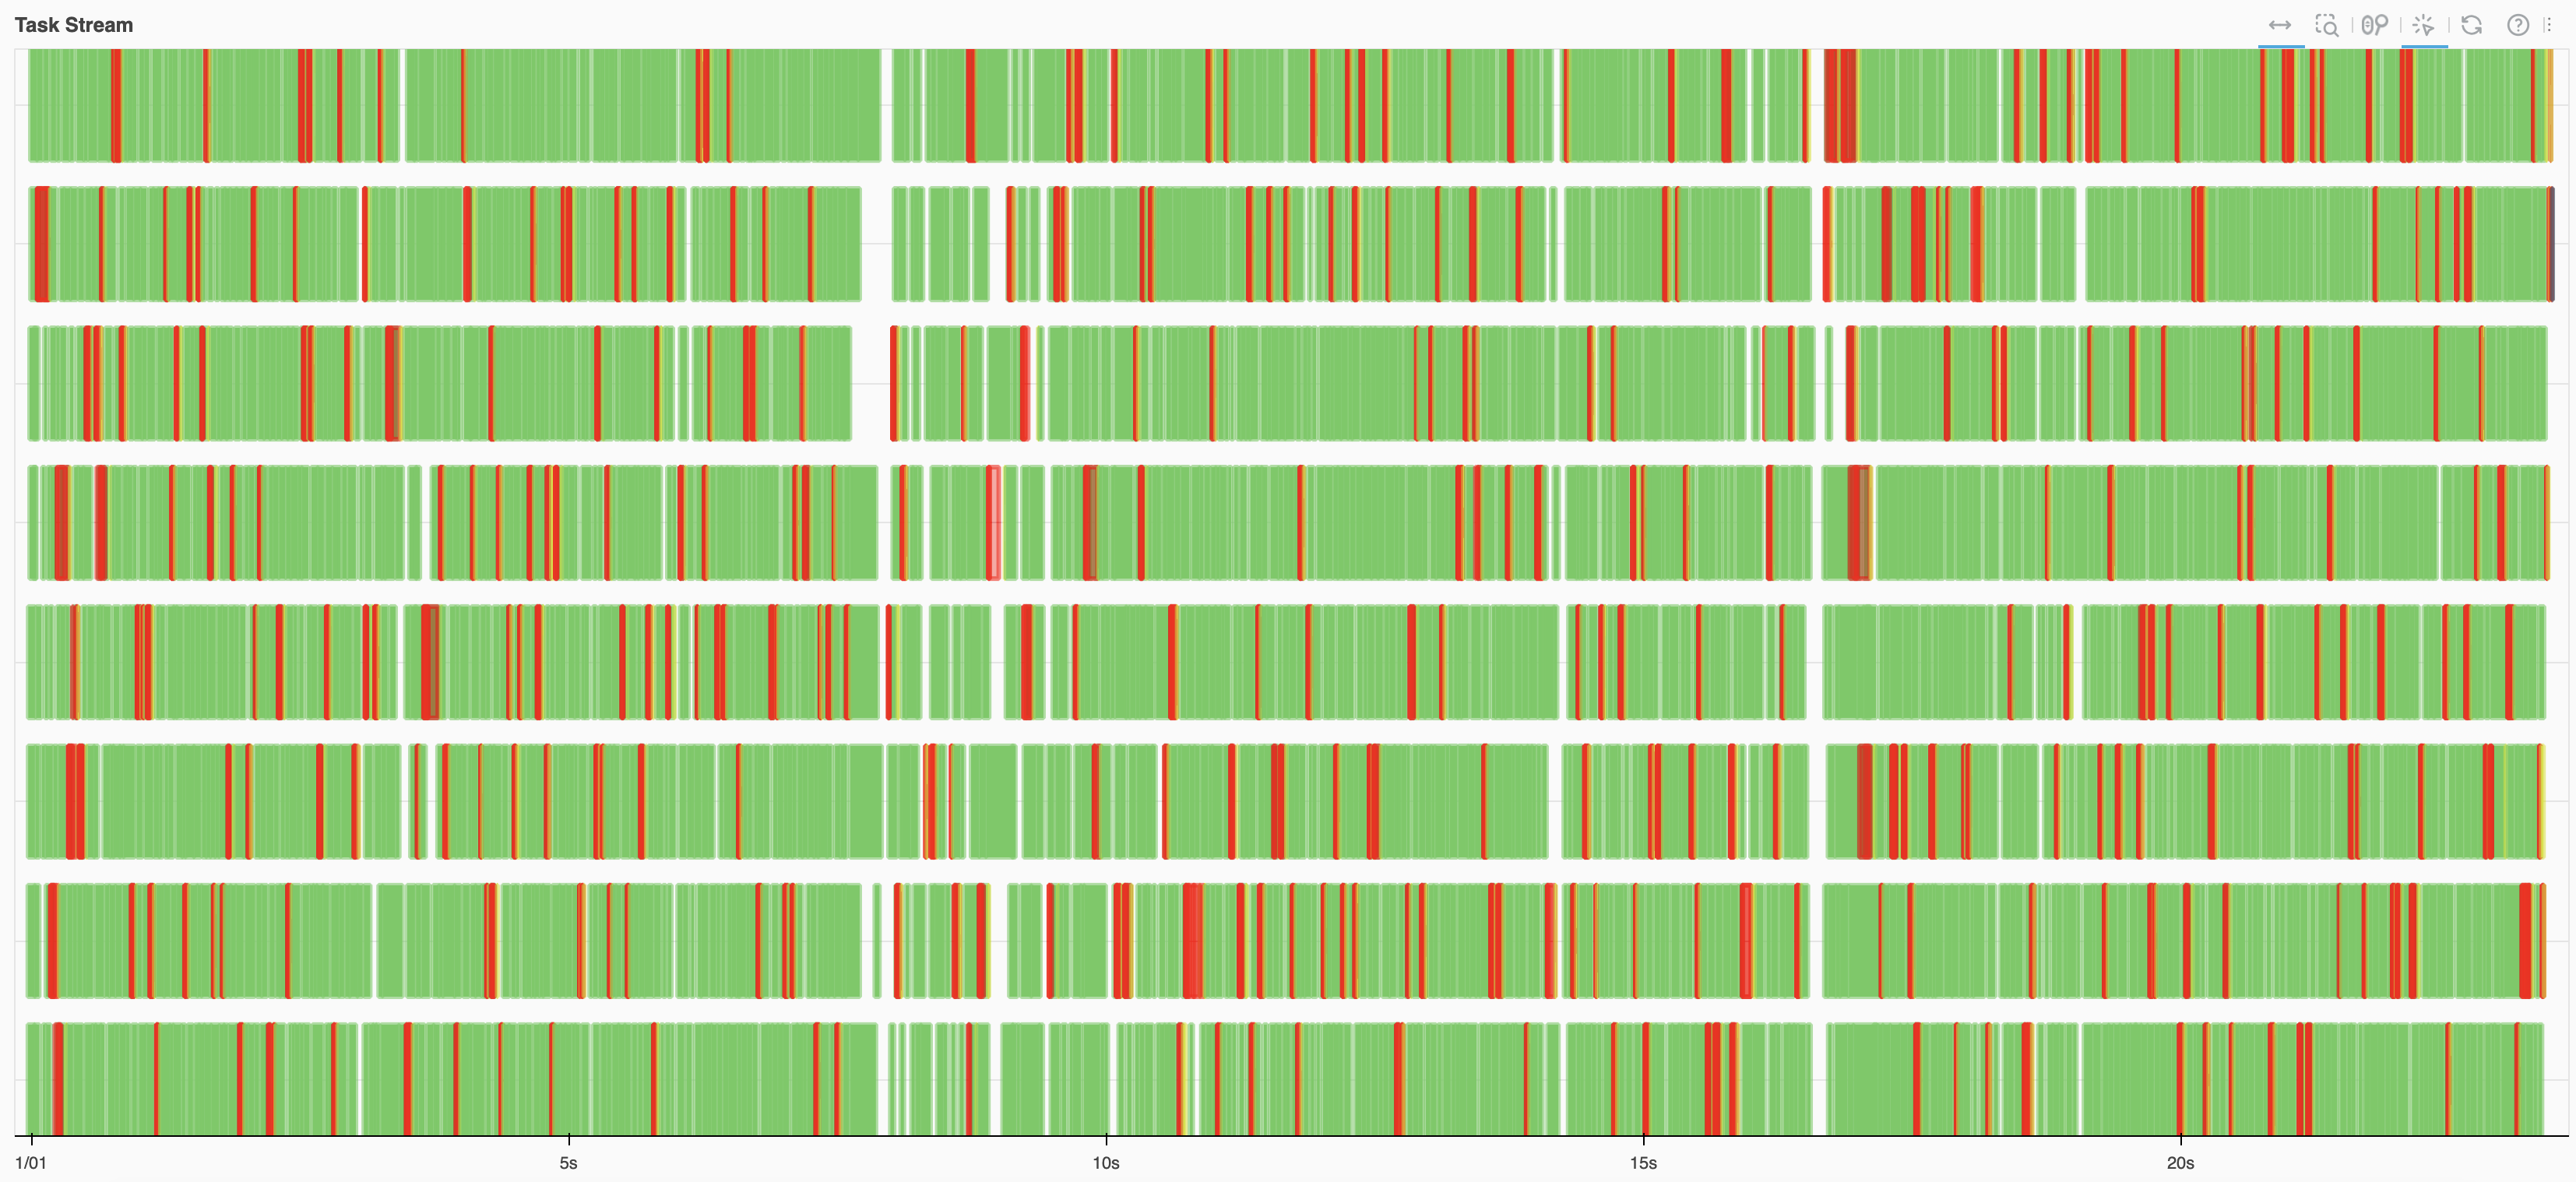

内存方面，尽量不要出现橙色、灰色或者红色，出现灰色或红色时说明数据切分得太大，超出了 Dask Worker 的内存范围。下图展示了内存使用状态变化情况。

■ 蓝色
内存数据在正常范围内  
■ 橙色
内存数据接近卸载的阈值  
■ 红色
某个 Dask Worker 暂停  
■ 灰色
内存数据卸载到硬盘上  


### 设置数据块大小

Dask Array 和 Dask DataFrame 都提供了设置数据块的方式。

可以在初始化时就设定每个数据块的大小，比如 x = da.ones((10, 10), chunks=(5, 5))，**chunks 参数用来设置每个数据块大小**。也可以在程序运行过程中调整，比如 Dask Array 的 rechunk() 和 Dask DataFrame 的 repartition()。Dask Array 的 rechunk(chunks=...) 在程序运行过程中调整数据块大小，chunks 参数可以是 int 表示切分成多少个数据块，也可以是 (5, 10, 20) 这样的 tuple，表示单个矩阵的维度大小；Dask DataFrame 的 **repartition(npartitions=...) 将数据切分成多少个 Partition**。